# Asian Call Option Pricing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy.stats import norm

Let the underlying price have risk-neutral SDE:

$ \frac{dS_t}{S_t} = r dt + \sigma dW_t $

An Asian option with maturity $T$ and strike $K$ has payoff:

$\left(\frac{1}{m} \sum_{i=1}^{m} S_{t_i} - K\right)^{+} $, where $t_i = iT/m$.  

We compare Monte Carlo estimation of the price with the log-normal approximation of Hull Ch.~26 that uses the Black-Scholes formula, <br> 
and with a normal approximation:
$
\frac{1}{m} \sum_{i=1}^{m} S_{t_i} \approx_\text{d}N\left[F, \sigma\sqrt{T}\right]\; \text{using the Bachelier call formula:}
$
$
C = e^{-rT} \left( (F - K)\Phi(Z) + \sigma\sqrt{T} \phi(Z) \right),
$
<br>where $F$ is the forward price at maturity, $Z = \frac{F-K}{\sigma\sqrt{T}}$, and $\Phi$ and $\phi$ are the standard normal CDF and PDF, respectively.

As per Hull, $F_i = \mathbb{E}[S_{t_i}] = S_0e^{rt_i}$ and $G_{ij}=\mathbb{E}[S_{t_i}S_{t_j}] = F_iF_j e^{\sigma^2 \min(t_i, t_j)}$, and then the first and second moments of the average are:

$
M_1= \mathbb{E}[S_t] = \frac{1}{m} \sum_{i=1}^{m} F_i
$

$
M_2 =\mathbb{E}[S_T^2] = \frac{1}{m^2} \sum_{i,j=1}^{m} G_{ij}.
$

The log-Normal approximation is
$
\ln\left(\frac{\bar S_T}{M_1}\right) \approx \text{N}\left( -\frac{1}{2} \ln\left(\frac{M_2}{M_1^2}\right),\; \ln\left(\frac{M_2}{M_1^2}\right) \right),
$
and then we approximate the Asian Option price with the Black-Scholes formula with inputs $S_0 = e^{-rT}M_1$ and $\sigma^2 = \frac{\log(M_2/M_1^2)}{T}$. 

For the Bachelier approximation, we take inputs$F=M_1$ and $\hat{\sigma}^2= (M_2-M_1^2)/T$.

We generate 5,000 Monte Carlo sample paths and use them to evaluate the price of this options for $T=1$  and $T=5$, with $m=4T$, $S_0=100$, $r=0.05$, $\sigma=0.2$ and for a range of strikes $K=90 : 120$


In [2]:
# Initial Parameters
T = 1
m = int(T * 4)
S0 = 100
r = 0.05
sigma = 0.2
# MC Paths
N = 5000
K=np.arange(90, 121)
disc = exp(-r * T)
ti = np.linspace(T / m ,T, m)
dt = ti[1]-ti[0]

## Monte Carlo Asian Call Price

In [3]:
# Generate a m x N multivariate standard normal r.v
Z = np.random.normal(0, 1, (m, N))
# Cumulative Standard Brownian path across the MC paths
W = np.cumsum(Z, axis=0)* sqrt(dt)
# Create the underlying asset paths using the Geometric BM
S = S0 * np.exp((r - 0.5 * sigma**2) * ti.reshape((m, 1)) + sigma * W)
# Compute the 5,000 average final prices at the end of the period m
S_bar = np.mean(S, axis=0)
# Create the Strikes x Samples space to avoid for loops
[Sv, Kv] = np.meshgrid(S_bar, K)
# Final Payoffs for each strike and each sample:
final_payoffs = np.maximum((Sv - Kv),0)
# Average Payoff for each Strike is the mean of the MC paths
average_payoffs = np.mean(final_payoffs, axis=1)
# Call price is the discounted average final payoff
calls_MC = disc * average_payoffs
# Collect the MC price
asian_call = pd.DataFrame({"MC Price":calls_MC}, index=K)
asian_call.index.rename("Strike", inplace=True)

## Log-Normal Approximation of the Asian Call Price using the BS Formula

In [4]:
# Define a BS routine:
def BS_C(S, K, sigma, t, T, r, q):
    d1 = (np.log(S / K) + (r - q + ((sigma**2) / 2)) * (T - t)) / (sigma * sqrt(T - t))
    d2 =(np.log(S / K) + (r - q - ((sigma**2) / 2)) * (T - t)) / (sigma * sqrt(T - t))
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    C = (S * exp(- q * (T - t)) * Nd1) - (K * exp(- r * (T - t)) * Nd2)
    return C

In [5]:
#Compute the parameters of the lognormal approximation:
M1_sum=0
M2_sum=0
for i in range(1, m+1):
    t1 = i * (T / m)
    for j in range(1, m+1):
        t2 = j * (T / m)
        F1 = S0 * exp(r * t1)
        F2 = S0 * exp(r * t2)
        G = F1 * F2 * exp((sigma**2) * min(t1, t2))
        M2_sum = M2_sum + G
    M1_sum = M1_sum + F1
M1 = M1_sum / m
M2 = M2_sum / (m**2)
S0_hat = disc * M1
sigma_hat = sqrt(log(M2 / (M1**2)) / T)
# Estimate the Asian call price using the BS formula
calls_BS = BS_C(S0_hat, K, sigma_hat, 0, T, r, 0)
# Collect the Prices
asian_call["Log-Normal Approx"] = calls_BS

##  Bachelier Normal Approximation of the Asian Call Price

In [6]:
# Define a Bachelier Call routine:
def bachieler_call(F, K, Z, sigma, T, disc):
    C = disc * sigma_hat * sqrt(T) *norm.pdf(Z) + disc * (M1 - K) * norm.cdf(Z) 
    return C

In [7]:
# Compute the Bachelier call price
sigma_hat = sqrt(M2 - M1**2) / sqrt(T)
F = S0 * exp(r * T)
Z = (M1 - K) /( sigma_hat * sqrt(T)) ;
call_bachelier = bachieler_call(F, K, Z, sigma_hat, T, disc)
# Collect the prices
asian_call["Bachelier Normal Approx"] = call_bachelier

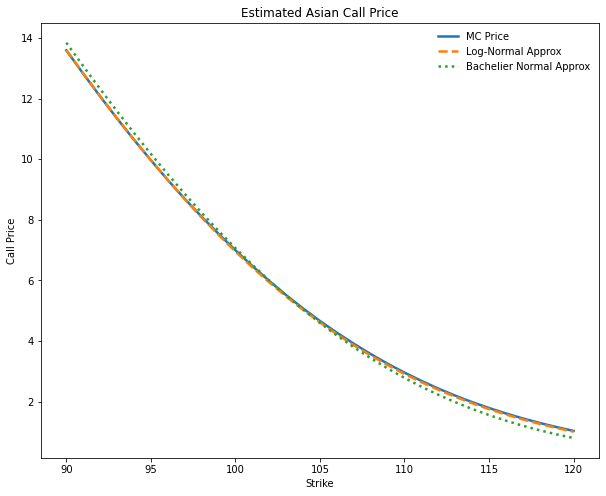

In [8]:
# Visualize the call prices
asian_call.plot(figsize=(10,8), style=["", "--", ":"], linewidth=2.5)
plt.legend(frameon=False)
plt.ylabel("Call Price")
plt.title("Estimated Asian Call Price")
plt.show()

In [9]:
asian_call

,MC Price,Log-Normal Approx,Bachelier Normal Approx
Strike,,,
90,13.594123,13.605087,13.846405
91,12.822178,12.833070,13.073164
92,12.072547,12.082262,12.318390
93,11.344970,11.353816,11.583172
94,10.643995,10.648786,10.868563
95,9.966347,9.968118,10.175565
96,9.315392,9.312635,9.505119
97,8.694685,8.683026,8.858091
98,8.103338,8.079844,8.235262
